In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import catboost as cb
import time
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import StratifiedKFold, KFold
from matplotlib.pyplot import plot, show, title
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None) 
    
df_train = pd.read_csv('data/A榜-训练集_海上风电预测_气象变量及实际功率数据.csv', encoding='gbk')
# df_train = pd.read_csv('data/A榜-训练集_海上风电预测_气象变量及实际功率数据-清洗后的数据.csv', encoding='gbk')
# df_train = pd.read_csv('data/A榜-训练集_海上风电预测_气象变量及实际功率数据-清洗后的数据3.csv', encoding='gbk')
df_test = pd.read_csv('data/A榜-测试集_海上风电预测_气象变量数据.csv', encoding='gbk')

add_df = pd.read_csv('data/A榜-训练集_海上风电预测_基本信息.csv', encoding='gbk')
# add_df = pd.read_csv('df_train/A榜-训练集_海上风电预测_基本信息.csv')
print(df_test.columns)
df = pd.concat([df_train, df_test])
df = df.merge(add_df[['站点编号', '装机容量(MW)']], on='站点编号', how='left')
df['站点编号_le'] = df['站点编号'].map(lambda x: int(x[1]))

df['time'] = pd.to_datetime(df['时间'], format='mixed')
df['day'] = df['time'].dt.day
df['weekday'] = df['time'].dt.weekday
df['hour'] = df['time'].dt.hour
df['month'] = df['time'].dt.month
df['minute'] = df['time'].dt.minute

# df['站点编号'] = df['站点编号'].astype('category')
# df['hour_sin'] = np.sin(df['hour'] / 23 * 2 * np.pi)
# df['hour_cos'] = np.cos(df['hour'] / 23 * 2 * np.pi)
# df['minute_sin'] = np.sin(df['minute'] / 59 * 2 * np.pi)
# df['minute_cos'] = np.cos(df['minute'] / 59 * 2 * np.pi)
df['time_96'] = df.apply(lambda x: (x['hour'] * 60 + x['minute']) / 15 + 1, axis=1)

# df['num_samples'] = list(range(len(df)))


# for col in ['10米风速（10m/s）','100m风速（100m/s）']:
#     df[col+'_squ'] = df[col] ** 2
#     df[col+'_cub'] = df[col] ** 3
#     df[col+'_mean'] = df[col].mean()
#     df[col+'_max'] = df[col].max()
#     df[col+'_min'] = df[col].min()
#     df[col+'_std'] = df[col].std()
#     df[col+'_25'] = df[col].quantile(0.25)
#     df[col+'_50'] = df[col].median()
#     df[col+'_75'] = df[col].quantile(0.75)


df_fs100_mean = df['100m风速（100m/s）'].groupby([df['站点编号'],df['month'],df['weekday'],df['hour']]).mean()
df_fs10_mean = df['10米风速（10m/s）'].groupby([df['站点编号'],df['month'],df['weekday'],df['hour']]).mean()
merged_df = pd.merge(df, df_fs100_mean, on=['站点编号','month','weekday', 'hour'])
merged_df = pd.merge(merged_df, df_fs10_mean, on=['站点编号','month','weekday', 'hour'])
# print(fs100_mean)
# print(fs10_mean)

merged_df = pd.merge(df, df_fs100_mean, on=['站点编号','weekday', 'hour'])
merged_df = pd.merge(merged_df, df_fs10_mean, on=['站点编号','weekday', 'hour'])

# merged_df = merged_df.assign(m100fs_mean=merged_df['100m风速（100m/s）_y'],m10fs_mean=merged_df['10米风速（10m/s）_y'])
# merged_df = merged_df.drop(['100m风速（100m/s）_y', '10米风速（10m/s）_y'], axis=1)
merged_df.rename(columns={'100m风速（100m/s）_x':'100m风速（100m/s）', '10米风速（10m/s）_x':'10米风速（10m/s）',
                          '100m风速（100m/s）_y':'100m风速（100m/s）_mean', '10米风速（10m/s）_y':'10米风速（10m/s）_mean'}, inplace=True)

merged_df = merged_df.sort_values(by=['站点编号','time'],ascending=[True, True])
df = merged_df.reset_index(drop=True)
print(df[0:5])

for col in ['10米风向（°)', '100m风向（°)']:
    df[col+"_sin"]=df[col].apply(lambda x: np.sin(x/180*np.pi))
    df[col+"_cos"]=df[col].apply(lambda x: np.cos(x/180*np.pi))
    
print(f"gap feature")
# gaps=[1,2,4,7,15,30,50,80]
gaps=[1,2,4,8,16,32,48,96,192,288]
for gap in gaps:
#     for col in ['气压(Pa）', '相对湿度（%）', '云量', '10米风速（10m/s）', '10米风向（°)', '温度（K）',
#            '辐照强度（J/m2）', '降水（m）', '100m风速（100m/s）', '100m风向（°)']:
    for col in ['气压(Pa）', '相对湿度（%）', '云量', '10米风速（10m/s）',  '温度（K）','降水（m）', '100m风速（100m/s）']:
        df[col+f"_shift{gap}"]=df[col].groupby(df['站点编号']).shift(gap, fill_value=0)
        df[col+f"_gap{gap}"]=df[col+f"_shift{gap}"]-df[col]
        df.drop([col+f"_shift{gap}"],axis=1,inplace=True)


# print("one hot encoder")
# for col in ['站点编号']:
#     unique_value=df[col].unique()
#     for value in unique_value:
#         df[col+"_"+str(value)]=(df[col]==value)
#     df.drop([col],axis=1,inplace=True)


LABEL = '出力(MW)'
df.loc[df[LABEL]=='<NULL>', LABEL] = None
print('1')
df.bfill(inplace=True)

# df_train = df[df[LABEL].notna()]
# df_test = df[df[LABEL].isna()].reset_index(drop=True)

df_train = df[df['time']< '2023-05-01 0:0:0']
df_test = df[df['time'] >= '2023-05-01 0:0:0']

print(len(df_train))
df_train = df_train[df_train[LABEL]!='<NULL>'].reset_index(drop=True)
df_train[LABEL] = df_train[LABEL].astype('float32')
print(len(df_train))

# 出力归一化
df_train[LABEL] = df_train[LABEL]/df_train['装机容量(MW)']

params_lgb = {
    'learning_rate': 0.03,
    'boosting_type': 'gbdt',
    'objective': 'mse',
    'metric': 'mse',
    'num_leaves': 64,
    'verbose': 1,
    'seed': 13,
    'n_jobs': -1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.9,
    'bagging_freq': 4,
}

params_cb = {
    'learning_rate': 0.03,
    'loss_function': "RMSE",
    'eval_metric': "RMSE",
    'min_data_in_leaf': 64,
    'random_seed': 13,
    'logging_level': 'Silent',
    'use_best_model': True,
    'one_hot_max_size': 5,   #类别数量多于此数将使用ordered target statistics编码方法,默认值为2。
    'boosting_type':"Ordered", #Ordered 或者Plain,数据量较少时建议使用Ordered,训练更慢但能够缓解梯度估计偏差。
    'max_ctr_complexity': 2, #特征组合的最大特征数量，设置为1取消特征组合，设置为2只做两个特征的组合,默认为4。
    'nan_mode': 'Min' 
}

importance = 0
# MODEL_TYPE = 'lgb'

print(df_train.head())


sub_train_df = df_train[df_train['time'] < '2023-02-01 0:0:0']
sub_val_df = df_train[df_train['time'] >= '2023-02-01 0:0:0']


# feats = [f for f in sub_train_df.columns if f not in [LABEL, '时间', 'time',  '站点编号', 'min']]
# feats = [f for f in sub_train_df.columns if f not in [LABEL, '时间', 'time', '站点编号_le']]
feats = [f for f in sub_train_df.columns if f not in [LABEL, '时间', 'time',  '站点编号', 'minute']]
print(feats)

train = lgb.Dataset(sub_train_df[feats],
                    sub_train_df[LABEL])
val = lgb.Dataset(sub_val_df[feats],
                  sub_val_df[LABEL])


model = lgb.train(params_lgb, train, valid_sets=[train, val], num_boost_round=5000, callbacks=[lgb.early_stopping(100), lgb.log_evaluation(100)])
# model = lgb.train(params_lgb, train, valid_sets=[train, val], num_boost_round=500, categorical_feature=['站点编号'], callbacks=[lgb.early_stopping(100), lgb.log_evaluation(100)])
model_cat = cb.CatBoostRegressor(iterations=1000,  early_stopping_rounds = 100, **params_cb)
model_cat.fit(sub_train_df[feats], sub_train_df[LABEL], eval_set=(sub_val_df[feats], sub_val_df[LABEL]), verbose=True, plot=True)

val_pred = model.predict(sub_val_df[feats])
val_pred_cat = model_cat.predict(sub_val_df[feats])

s_mse = mse(sub_val_df[LABEL]*sub_val_df['装机容量(MW)'], val_pred*sub_val_df['装机容量(MW)'], squared=False)
s_mse_cat = mse(sub_val_df[LABEL]*sub_val_df['装机容量(MW)'], val_pred_cat*sub_val_df['装机容量(MW)'], squared=False)

val_pred_fusion = (val_pred + val_pred_cat)/2
s_mse_fusion = mse(sub_val_df[LABEL]*sub_val_df['装机容量(MW)'], val_pred_fusion*sub_val_df['装机容量(MW)'], squared=False)

score = 1/(1+s_mse)
print('score... %.5f'%score, 'rmse...%.5f'%s_mse)

score_cat = 1/(1+s_mse_cat)
print('score... %.5f'%score_cat, 'rmse...%.5f'%s_mse_cat)

score_fusion = 1/(1+s_mse_fusion)
print('score... %.5f'%score_fusion, 'rmse...%.5f'%s_mse_fusion)

print('feature importance of lightgbm:')
importance += model.feature_importance(importance_type='gain')
feats_importance = pd.DataFrame()
feats_importance['name'] = feats
feats_importance['importance'] = importance
print(feats_importance.sort_values('importance', ascending=False)[:30])

print('feature importance of catboost:')
print(model_cat.get_feature_importance(prettified=True)[:30])


plt.figure(figsize=(10,8), dpi=200)
plt.plot(sub_val_df[LABEL].values)
plt.plot(val_pred)
plt.show()

model = lgb.train(params_lgb, lgb.Dataset(df_train[feats], df_train[LABEL]), num_boost_round=model.best_iteration)
# model = lgb.train(params_lgb, lgb.Dataset(df_train[feats], df_train[LABEL]), categorical_feature=['站点编号'], num_boost_round=model.best_iteration)
params_cb['use_best_model'] = False
params_cb['iterations'] = model_cat.get_best_iteration()
model_cat = cb.CatBoostRegressor(**params_cb)
model_cat.fit(df_train[feats], df_train[LABEL], verbose=True, plot=True)

pred_y = model.predict(df_test[feats])

pred_y_cat = model_cat.predict(df_test[feats])
pred_y_fusion = (pred_y+pred_y_cat)/2

# df_test[LABEL] = pred_y*df_test['装机容量(MW)']
df_test[LABEL] = pred_y_fusion*df_test['装机容量(MW)']

# df_test[['站点编号','时间','出力(MW)']].to_csv('ans/lgb_base_%.5f.csv'%score, index=False)
df_test[['站点编号','时间','出力(MW)']].to_csv('ans/lgb_base_%.5f.csv'%score_fusion, index=False)

Index(['站点编号', '时间', '气压(Pa）', '相对湿度（%）', '云量', '10米风速（10m/s）', '10米风向（°)',
       '温度（K）', '辐照强度（J/m2）', '降水（m）', '100m风速（100m/s）', '100m风向（°)'],
      dtype='object')
  站点编号             时间       气压(Pa）  相对湿度（%）        云量  10米风速（10m/s）  10米风向（°)  \
0   f1  2022-1-3 0:00  102249.6094  74.8513  0.007812        7.7041   26.5195   
1   f1  2022-1-3 0:00  102249.6094  74.8513  0.007812        7.7041   26.5195   
2   f1  2022-1-3 0:00  102249.6094  74.8513  0.007812        7.7041   26.5195   
3   f1  2022-1-3 0:00  102249.6094  74.8513  0.007812        7.7041   26.5195   
4   f1  2022-1-3 0:00  102249.6094  74.8513  0.007812        7.7041   26.5195   

      温度（K）  辐照强度（J/m2）     降水（m）  100m风速（100m/s）  100m风向（°) 出力(MW)  装机容量(MW)  \
0  286.0695         0.0  0.000008           9.082    27.5093  17.26        48   
1  286.0695         0.0  0.000008           9.082    27.5093  17.26        48   
2  286.0695         0.0  0.000008           9.082    27.5093  17.26        48   
3  286.0695         

MemoryError: Unable to allocate 21.6 GiB for an array with shape (87, 33384960) and data type float64

In [2]:
df_res1 = pd.read_csv('ans/lgb_base_0.04925.csv', encoding='utf-8')
df_res2 = pd.read_csv('ans/bilstm-UTF-8.csv', encoding='utf-8')
print(df_res1, df_res2)
df_res1['出力(MW)'] = (df_res1['出力(MW)']+df_res2['出力(MW)'])/2
df_res1[['站点编号','时间','出力(MW)']].to_csv('ans/lgb_bilstm_2.csv', index=False)

      站点编号               时间    出力(MW)
0       f1    2023-5-1 0:00  5.575213
1       f1    2023-5-1 0:15  5.652277
2       f1    2023-5-1 0:30  5.868383
3       f1    2023-5-1 0:45  5.907403
4       f1    2023-5-1 1:00  5.960931
...    ...              ...       ...
44155   f5  2023-7-31 22:45  3.570079
44156   f5  2023-7-31 23:00  3.923680
44157   f5  2023-7-31 23:15  3.399710
44158   f5  2023-7-31 23:30  3.630160
44159   f5  2023-7-31 23:45  2.856356

[44160 rows x 3 columns]       站点编号               时间    出力(MW)
0       f1    2023-5-1 0:00  5.668540
1       f1    2023-5-1 0:15  5.734170
2       f1    2023-5-1 0:30  6.168911
3       f1    2023-5-1 0:45  6.114414
4       f1    2023-5-1 1:00  6.774835
...    ...              ...       ...
44155   f5  2023-7-31 22:45  3.485310
44156   f5  2023-7-31 23:00  3.850666
44157   f5  2023-7-31 23:15  3.591922
44158   f5  2023-7-31 23:30  3.709665
44159   f5  2023-7-31 23:45  3.578127

[44160 rows x 3 columns]


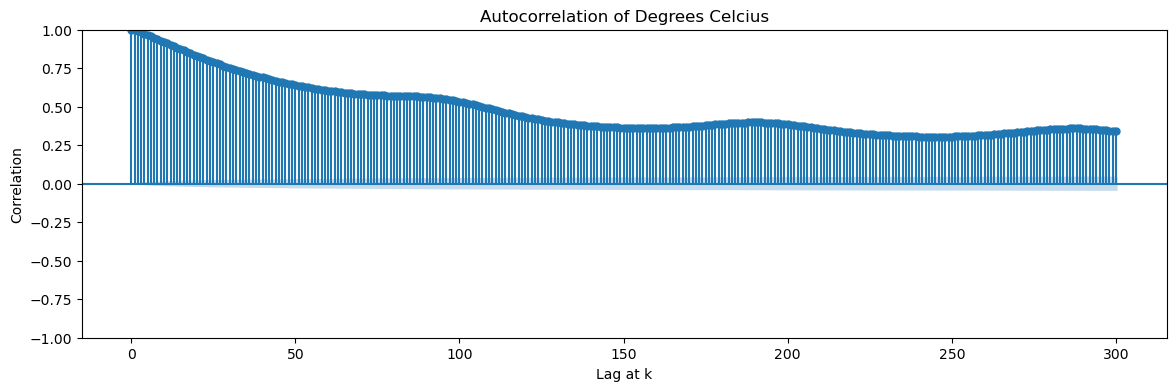

In [91]:
from matplotlib import rcParams
from statsmodels.graphics.tsaplots import plot_acf

LABEL = '出力(MW)'
df.loc[df[LABEL]=='<NULL>', LABEL] = None
df.bfill(inplace=True)
df[LABEL] = df[LABEL].astype('float32')

rcParams['figure.figsize'] = 14, 4
fig = plot_acf(df['100m风速（100m/s）'], lags=300)

plt.title('Autocorrelation of Degrees Celcius')
plt.ylabel('Correlation')
plt.xlabel('Lag at k')
fig.show()

In [67]:
df['weekday'] = df['time'].dt.weekday
df['day'] = df['time'].dt.day
print(df[0:5])
# print(df.groupby(['站点编号','weekday']).describe())
# fs_mean = df.groupby(['站点编号','weekday']).agg({'100m风速（100m/s）':'mean'})
# print(fs_mean)
# df['100m风速（100m/s）'+'_mean'] = df['100m风速（100m/s）'].groupby(df['站点编号','weekday']).mean()
# df['100m风速（100m/s）'+'_mean'] = df['100m风速（100m/s）'].groupby(df['站点编号']).mean()
# print(df[1:5])
df2 = df
print(len(df))
fs100_mean = df['100m风速（100m/s）'].groupby([df['站点编号'],df['weekday'],df['hour']]).mean()
fs10_mean = df['10米风速（10m/s）'].groupby([df['站点编号'],df['weekday'],df['hour']]).mean()
# print(fs100_mean)
# print(fs10_mean)

merged_df = pd.merge(df, fs100_mean, on=['站点编号','weekday', 'hour'])
merged_df = pd.merge(merged_df, fs10_mean, on=['站点编号','weekday', 'hour'])
print(merged_df[0:5])
merged_df = merged_df.assign(m100fs_mean=merged_df['100m风速（100m/s）_y'],m10fs_mean=merged_df['10米风速（10m/s）_y'])
merged_df = merged_df.drop(['100m风速（100m/s）_y', '10米风速（10m/s）_y'], axis=1)
print(merged_df[0:5])
merged_df = merged_df.sort_values(by=['站点编号','time'],ascending=[True, True])
merged_df = merged_df.reset_index(drop=True)
print(merged_df[0:5])
# for key, value in fs_mean:
#     print(key)
#     print(value)
#     print("")

  站点编号             时间       气压(Pa）  相对湿度（%）        云量  10米风速（10m/s）_x  \
0   f1  2022-1-3 0:00  102249.6094  74.8513  0.007812          7.7041   
1   f1  2022-1-3 0:15  102252.0355  74.7530  0.000924          7.7710   
2   f1  2022-1-3 0:30  102248.5900  74.4995  0.003009          7.8272   
3   f1  2022-1-3 0:45  102240.4725  74.1432  0.011402          7.8637   
4   f1  2022-1-3 1:00  102228.8828  73.7366  0.023438          7.8781   

   10米风向（°)     温度（K）  辐照强度（J/m2）     降水（m）  100m风速（100m/s）_x  100m风向（°)  \
0   26.5195  286.0695         0.0  0.000008            9.0820    27.5093   
1   23.5766  285.8647         0.0  0.000008            9.1374    24.7151   
2   21.5451  285.6935         0.0  0.000008            9.1856    22.7445   
3   20.2394  285.5512         0.0  0.000008            9.2158    21.4374   
4   19.4870  285.4330         0.0  0.000008            9.2237    20.6417   

  出力(MW)  装机容量(MW)  站点编号_le                time  day  weekday  hour  month  \
0  17.26        48        

KeyError: '100m风速（100m/s）'

In [5]:
print(df[100:110])

    站点编号             时间       气压(Pa）  相对湿度（%）        云量  10米风速（10m/s）  \
100   f1  2022-1-4 1:00  102101.2969  43.3933  0.078125        6.1112   
101   f1  2022-1-4 1:15  102092.3073  44.6036  0.085182        6.1786   
102   f1  2022-1-4 1:30  102080.7735  45.3168  0.086477        6.2591   
103   f1  2022-1-4 1:45  102067.3452  45.7718  0.087503        6.3394   
104   f1  2022-1-4 2:00  102052.6719  46.2074  0.093750        6.4062   
105   f1  2022-1-4 2:15  102037.5698  46.8036  0.111210        6.4489   
106   f1  2022-1-4 2:30  102023.5220  47.5048  0.147840        6.4662   
107   f1  2022-1-4 2:45  102012.1780  48.1962  0.212120        6.4592   
108   f1  2022-1-4 3:00  102005.1875  48.7630  0.312500        6.4288   
109   f1  2022-1-4 3:15  102003.4847  49.1226  0.451560        6.3782   

     10米风向（°)     温度（K）  辐照强度（J/m2）         降水（m）  100m风速（100m/s）  100m风向（°)  \
100    1.7205  286.5377         0.0  0.000000e+00          8.4188     7.2198   
101    1.4339  286.5182         0.0 

In [62]:
params_cb['use_best_model'] = False
params_cb['iterations'] = model_cat.get_best_iteration()
model_cat = cb.CatBoostRegressor(**params_cb)
model_cat.fit(df_train[feats], df_train[LABEL], verbose=True, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [63]:
pred_y_cat = model_cat.predict(df_test[feats])
pred_y_fusion = (pred_y+pred_y_cat)/2

# df_test[LABEL] = pred_y*df_test['装机容量(MW)']
df_test[LABEL] = pred_y_fusion*df_test['装机容量(MW)']

# df_test[['站点编号','时间','出力(MW)']].to_csv('ans/lgb_base_%.5f.csv'%score, index=False)
df_test[['站点编号','时间','出力(MW)']].to_csv('ans/lgb_base_%.5f.csv'%score_fusion, index=False)

In [46]:
print(model_cat.get_feature_importance(prettified=True)[:30])

              Feature Id  Importances
0         100m风速（100m/s）    14.881744
1     100m风速（100m/s）_cub    11.987800
2     100m风速（100m/s）_squ    11.588024
3                站点编号_le     8.912412
4               装机容量(MW)     4.321363
5           10米风速（10m/s）     3.857386
6           10米风向（°)_cos     3.067667
7          100m风向（°)_cos     3.002037
8       10米风速（10m/s）_cub     2.982832
9       10米风速（10m/s）_squ     2.605273
10                气压(Pa）     1.679698
11                 温度（K）     1.675823
12                 降水（m）     1.496285
13          降水（m）_gap192     1.460827
14                 month     1.438892
15          10米风向（°)_sin     1.332104
16         100m风向（°)_sin     1.317056
17  100m风速（100m/s）_gap16     1.309311
18          气压(Pa）_gap96     1.254580
19          温度（K）_gap192     1.017003
20         气压(Pa）_gap288     0.929068
21          降水（m）_gap288     0.911467
22          温度（K）_gap288     0.834891
23       100m风向（°)_gap48     0.753767
24           降水（m）_gap96     0.734749
25          

In [47]:
print(feats_importance.sort_values('importance', ascending=False)[:30])

                     name    importance
8          100m风速（100m/s）  84123.268067
19     100m风速（100m/s）_squ  15567.801610
3            10米风速（10m/s）   8466.845898
11                站点编号_le   3452.650916
10               装机容量(MW)   2068.116154
24          100m风向（°)_cos   1737.428582
22           10米风向（°)_cos    941.491998
9               100m风向（°)    907.497422
73   100m风速（100m/s）_gap16    828.354671
7                   降水（m）    761.623503
95           气压(Pa）_gap96    718.305258
122          降水（m）_gap288    689.371818
5                   温度（K）    658.576792
112          降水（m）_gap192    637.863407
0                  气压(Pa）    622.455932
23          100m风向（°)_sin    611.953618
4                10米风向（°)    518.474082
102           降水（m）_gap96    500.641103
115         气压(Pa）_gap288    495.095053
18       10米风速（10m/s）_cub    494.893824
94        100m风向（°)_gap48    453.384743
21           10米风向（°)_sin    444.333762
120          温度（K）_gap288    415.548699
110          温度（K）_gap192    401.435997


In [51]:
print(model_cat.get_feature_importance(prettified=True)[-30:])

              Feature Id  Importances
95        10米风向（°)_gap16     0.013942
96       辐照强度（J/m2）_gap1     0.012317
97           气压(Pa）_gap4     0.011158
98       辐照强度（J/m2）_gap2     0.009906
99              云量_gap48     0.007937
100      辐照强度（J/m2）_gap8     0.005413
101         相对湿度（%）_gap4     0.005092
102          气压(Pa）_gap1     0.000000
103         相对湿度（%）_gap1     0.000000
104              云量_gap1     0.000000
105        10米风向（°)_gap1     0.000000
106           降水（m）_gap1     0.000000
107       100m风向（°)_gap1     0.000000
108          气压(Pa）_gap2     0.000000
109         相对湿度（%）_gap2     0.000000
110              云量_gap2     0.000000
111    10米风速（10m/s）_gap2     0.000000
112        10米风向（°)_gap2     0.000000
113           降水（m）_gap2     0.000000
114  100m风速（100m/s）_gap2     0.000000
115       100m风向（°)_gap2     0.000000
116              云量_gap4     0.000000
117        10米风向（°)_gap4     0.000000
118           降水（m）_gap4     0.000000
119       100m风向（°)_gap4     0.000000
120         

In [50]:
print(feats_importance.sort_values('importance', ascending=False)[-30:])

                   name  importance
20   100m风速（100m/s）_cub   22.688656
45          气压(Pa）_gap4   21.681755
30           温度（K）_gap1   21.436572
56         相对湿度（%）_gap8   20.535656
50           温度（K）_gap4   19.829179
31      辐照强度（J/m2）_gap1   17.796809
28    10米风速（10m/s）_gap1   17.272564
57              云量_gap8   12.151867
41      辐照强度（J/m2）_gap2   10.983070
49        10米风向（°)_gap4   10.702658
29        10米风向（°)_gap1    9.498237
52           降水（m）_gap4    8.967236
32           降水（m）_gap1    8.511863
46         相对湿度（%）_gap4    8.236831
40           温度（K）_gap2    7.870480
51      辐照强度（J/m2）_gap4    7.528484
25          气压(Pa）_gap1    7.503066
26         相对湿度（%）_gap1    7.456437
43  100m风速（100m/s）_gap2    6.246414
34       100m风向（°)_gap1    5.884441
42           降水（m）_gap2    5.145167
35          气压(Pa）_gap2    5.094187
36         相对湿度（%）_gap2    4.936386
54       100m风向（°)_gap4    3.794752
44       100m风向（°)_gap2    3.730027
38    10米风速（10m/s）_gap2    3.354677
37              云量_gap2    2

In [24]:
print(df.head())

  站点编号             时间       气压(Pa）  相对湿度（%）        云量  10米风速（10m/s）  10米风向（°)  \
0   f1  2022-1-3 0:00  102249.6094  74.8513  0.007812        7.7041   26.5195   
1   f1  2022-1-3 0:15  102252.0355  74.7530  0.000924        7.7710   23.5766   
2   f1  2022-1-3 0:30  102248.5900  74.4995  0.003009        7.8272   21.5451   
3   f1  2022-1-3 0:45  102240.4725  74.1432  0.011402        7.8637   20.2394   
4   f1  2022-1-3 1:00  102228.8828  73.7366  0.023438        7.8781   19.4870   

      温度（K）  辐照强度（J/m2）     降水（m）  100m风速（100m/s）  100m风向（°) 出力(MW)  装机容量(MW)  \
0  286.0695         0.0  0.000008          9.0820    27.5093  17.26        48   
1  285.8647         0.0  0.000008          9.1374    24.7151  16.78        48   
2  285.6935         0.0  0.000008          9.1856    22.7445  16.25        48   
3  285.5512         0.0  0.000008          9.2158    21.4374  15.37        48   
4  285.4330         0.0  0.000008          9.2237    20.6417  15.64        48   

   站点编号_le                